<a href="https://colab.research.google.com/github/cindyhfls/SpatialEmbeddedEquilibriumPropagation_Neuromatch_NeuroAI_TrustworthyHeliotrope/blob/main/equilibrium_propagation_toymodel_Tu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from https://github.com/smonsays/equilibrium-propagation/tree/master "run_energy_model_mnist.py"

**To-do:**

*Week 1 - Make the network architecture and train basic network, decide on the questions*
1. We first make a fake "distance" matrix by specifying the distance between each of the 1000x1000 pairs of units.
2. Implement spatial normalization through energy function?

*Week 2 - Calculating metrics to evaluate the network, each person pick a direction to test and produce a summary slide.*

In [11]:
# @title Clone Repository and Setup
!git clone https://github.com/cindyhfls/SpatialEmbeddedEquilibriumPropagation_Neuromatch_NeuroAI_TrustworthyHeliotrope.git
!cd /content/SpatialEmbeddedEquilibriumPropagation_Neuromatch_NeuroAI_TrustworthyHeliotrope/equilibrium-propagation-master/
!pip install vibecheck numpy matplotlib torch torchvision tqdm ipywidgets memory-profiler requests scikit-learn torchmetrics --quiet

fatal: destination path 'SpatialEmbeddedEquilibriumPropagation_Neuromatch_NeuroAI_TrustworthyHeliotrope' already exists and is not an empty directory.


In [27]:
!pip install numpy matplotlib torch torchvision tqdm requests scikit-learn torchmetrics --quiet


In [22]:
# @title Connect to Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# @title Check if there are checkpoints in Google Drive
file_path = '/content/drive/MyDrive/Neuromatch Academy Project Files: Trustworthy Helitrope Equlibrium/Tu/'

# List all files in the directory
files = os.listdir(file_path)

# Check for files with the '.pth' extension
pth_files = [f for f in files if f.endswith('.pth')]

if pth_files:
    print("Found .pth files:", pth_files)
else:
    print("No .pth files found.")

Found .pth files: ['checkpoint_epoch_1_modelclass_restr_hopfield_seed_42.pth', 'checkpoint_epoch_1_modelclass_restr_hopfield_seed_2019.pth']


In [29]:
# @title Import dependencies

# Import standard library dependencies
import os
import time
import gc
import logging
from pathlib import Path
import zipfile
import random
import contextlib
import io

# Import third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
#from ipywidgets import Layout
#from memory_profiler import profile
import requests
from sklearn.metrics import confusion_matrix
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
#import vibecheck

import argparse
import json
import sys

from lib import config, data, energy, train, utils

In [ ]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [38]:
# @title helper functions

def get_random_sample_dataloader(dataset, batch_size, M):
    indices = torch.randperm(len(dataset))[:M]
    sampler = torch.utils.data.SubsetRandomSampler(indices)
    sampled_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    return sampled_loader

def get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data):

    sampled_train_loader = get_random_sample_dataloader(train_dataset, batch_size, N_train_data)

    N_val_data = int(N_train_data / 9.0)
    if N_val_data < 30:
        N_val_data = int(30)
    sampled_val_loader = get_random_sample_dataloader(val_dataset, batch_size, N_val_data)

    return sampled_train_loader, sampled_val_loader

In [1]:
# @title Plotting functions

def plot_reconstructions(original_images, reconstructed_images, N_train_data, epochs):
    fig = plt.figure(figsize=(10, 5))
    rows, cols = 2, 6
    image_count = 0
    for i in range(1, rows * cols, 2):
        fig.add_subplot(rows, cols, i)
        plt.imshow(np.squeeze(original_images[image_count]), cmap='gray')
        plt.title(f"Original {image_count+1}", fontsize=8)
        plt.axis('off')

        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(np.squeeze(reconstructed_images[image_count]), cmap='gray')
        plt.title(f"Reconstructed {image_count+1}", fontsize=8)
        plt.axis('off')

        image_count += 1
    fig.suptitle(f"Training for {epochs} epochs with {N_train_data} points")
    plt.show()

In [30]:
# @title Data retrieval

import os
import requests
import hashlib
import zipfile

def download_file(fname, url, expected_md5):
    """
    Downloads a file from the given URL and saves it locally.
    """
    if not os.path.isfile(fname):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
            return
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
            return
        if hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
            return
        with open(fname, "wb") as fid:
            fid.write(r.content)

def extract_zip(zip_fname):
    """
    Extracts a ZIP file to the current directory.
    """
    with zipfile.ZipFile(zip_fname, 'r') as zip_ref:
        zip_ref.extractall(".")

# Details for the zip files to be downloaded and extracted
zip_files = [
    {
        "fname": "models.zip",
        "url": "https://osf.io/dms2n/download",
        "expected_md5": "2c88be8804ae546da6c6985226bc98e7"
    }
]

# Process zip files: download and extract
for zip_file in zip_files:
    download_file(zip_file["fname"], zip_file["url"], zip_file["expected_md5"])
    extract_zip(zip_file["fname"])

In [31]:
# @title Set random seed
def set_seed(seed=None, seed_torch=True):
	if seed is None:
		seed = np.random.choice(2 ** 32)
	random.seed(seed)
	np.random.seed(seed)
	if seed_torch:
		torch.manual_seed(seed)
		torch.cuda.manual_seed_all(seed)
		torch.cuda.manual_seed(seed)
		torch.backends.cudnn.benchmark = False
		torch.backends.cudnn.deterministic = True

In [33]:
# @title Helper functions for parsing input
def load_default_config(energy):
    """
    Load default parameter configuration from file.

    Args:
        tasks: String with the energy name

    Returns:
        Dictionary of default parameters for the given energy
    """
    if energy == "restr_hopfield":
        default_config = "etc/energy_restr_hopfield.json"
    elif energy == "cond_gaussian":
        default_config = "etc/energy_cond_gaussian.json"
    else:
        raise ValueError("Energy based model \"{}\" not defined.".format(energy))

    with open(default_config) as config_json_file:
        cfg = json.load(config_json_file)

    return cfg


def parse_shell_args(args):
    """
    Parse shell arguments for this script.

    Args:
        args: List of shell arguments

    Returns:
        Dictionary of shell arguments
    """
    parser = argparse.ArgumentParser(
        description="Train an energy-based model on MNIST using Equilibrium Propagation."
    )

    parser.add_argument("--batch_size", type=int, default=argparse.SUPPRESS,
                        help="Size of mini batches during training.")
    parser.add_argument("--c_energy", choices=["cross_entropy", "squared_error"],
                        default=argparse.SUPPRESS, help="Supervised learning cost function.")
    parser.add_argument("--dimensions", type=int, nargs="+",
                        default=argparse.SUPPRESS, help="Dimensions of the neural network.")
    parser.add_argument("--energy", choices=["cond_gaussian", "restr_hopfield"],
                        default="cond_gaussian", help="Type of energy-based model.")
    parser.add_argument("--epochs", type=int, default=argparse.SUPPRESS,
                        help="Number of epochs to train.")
    parser.add_argument("--fast_ff_init", action='store_true', default=argparse.SUPPRESS,
                        help="Flag to enable fast feedforward initialization.")
    parser.add_argument("--learning_rate", type=float, default=argparse.SUPPRESS,
                        help="Learning rate of the optimizer.")
    parser.add_argument("--log_dir", type=str, default="",
                        help="Subdirectory within ./log/ to store logs.")
    parser.add_argument("--nonlinearity", choices=["leaky_relu", "relu", "sigmoid", "tanh"],
                        default=argparse.SUPPRESS, help="Nonlinearity between network layers.")
    parser.add_argument("--optimizer", choices=["adam", "adagrad", "sgd"],
                        default=argparse.SUPPRESS, help="Optimizer used to train the model.")
    parser.add_argument("--seed", type=int, default=argparse.SUPPRESS,
                        help="Random seed for pytorch")

    return vars(parser.parse_args(args))

In [34]:
# @title Run this for conditional gaussian defaults
# change this input to make configuration
sys.argv = ['','--energy', 'cond_gaussian', '--epochs', '10','--seed','2019']

# Parse shell arguments as input configuration
user_config = parse_shell_args(sys.argv[1:])

# Load default parameter configuration from file for the specified energy-based model
cfg = load_default_config(user_config["energy"])

# Overwrite default parameters with user configuration where applicable
cfg.update(user_config)

# Setup global logger and logging directory
config.setup_logging(cfg["energy"] + "_" + cfg["c_energy"] + "_" + cfg["dataset"],
                      dir=cfg['log_dir'])
cfg

{'batch_size': 100,
 'beta': 1,
 'c_energy': 'cross_entropy',
 'dataset': 'mnist',
 'dimensions': [784, 1000, 10],
 'dynamics': {'dt': 0.1, 'n_relax': 20, 'tau': 1, 'tol': 0},
 'energy': 'cond_gaussian',
 'epochs': 10,
 'fast_ff_init': True,
 'learning_rate': 0.001,
 'nonlinearity': 'sigmoid',
 'optimizer': 'adam',
 'seed': 2019,
 'log_dir': ''}

In [35]:
# @title Run this for restricted hopfield defaults (original 2017 paper)
# change this input to make configuration
sys.argv = ['','--energy', 'restr_hopfield', '--epochs', '10','--seed','2019']

# Parse shell arguments as input configuration
user_config = parse_shell_args(sys.argv[1:])

# Load default parameter configuration from file for the specified energy-based model
cfg = load_default_config(user_config["energy"])

# Overwrite default parameters with user configuration where applicable
cfg.update(user_config)

# Setup global logger and logging directory
config.setup_logging(cfg["energy"] + "_" + cfg["c_energy"] + "_" + cfg["dataset"],
                      dir=cfg['log_dir'])
cfg

{'batch_size': 100,
 'beta': 1,
 'c_energy': 'squared_error',
 'dataset': 'mnist',
 'dimensions': [784, 1000, 10],
 'dynamics': {'dt': 0.1, 'n_relax': 50, 'tau': 1, 'tol': 0},
 'energy': 'restr_hopfield',
 'epochs': 10,
 'fast_ff_init': False,
 'learning_rate': 0.001,
 'nonlinearity': 'sigmoid',
 'optimizer': 'adam',
 'seed': 2019,
 'log_dir': ''}

In [42]:
# @title Load data
set_seed(2019) # not sure this actually fixed the MNIST loading?

# Create torch data loaders with the MNIST data set
data_train, data_val, data_test = data.create_mnist_loaders(cfg['batch_size'])

In [32]:
# @title Preparing the data (don't use this, somehow this one from tutorial does not work)
# with contextlib.redirect_stdout(io.StringIO()):

#     # Define a transformation pipeline for the MNIST dataset
#     mnist_transform = transforms.Compose([
#         transforms.Resize((32, 32)),  # Resize the images to 32x32 pixels
#         transforms.ToTensor(),  # Convert images to PyTorch tensors
#         transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # Normalize the images with mean and standard deviation
#     ])

#     # Load the MNIST training dataset with transformations applied
#     train_val_dataset = torchvision.datasets.MNIST(
#         root='./data',  # Directory to store/load the data
#         train=True,  # Specify to load the training set
#         transform=mnist_transform,  # Apply the transformation pipeline defined earlier
#         download=True  # Download the dataset if it's not already present
#     )

#     # Load the MNIST test dataset with transformations applied
#     test_dataset = torchvision.datasets.MNIST(
#         root='./data',  # Directory to store/load the data
#         train=False,  # Specify to load the test set
#         transform=mnist_transform,  # Apply the transformation pipeline defined earlier
#         download=True  # Download the dataset if it's not already present
#     )

#     # Split the training dataset into training and validation sets
#     train_size = int(0.9 * len(train_val_dataset))  # Calculate the size of the training set (90% of the original)
#     val_size = len(train_val_dataset) - train_size  # Calculate the size of the validation set (remaining 10%)
#     train_dataset, val_dataset = torch.utils.data.random_split(
#         dataset=train_val_dataset,  # Original training dataset to split
#         lengths=[train_size, val_size]  # Lengths of the resulting splits
#     )

#     # Split the test dataset into two halves: original and transfer sets
#     test_size_original = int(0.5 * len(test_dataset))  # Calculate the size of the original test set (50% of the original)
#     test_size_transfer = len(test_dataset) - test_size_original  # Calculate the size of the transfer test set (remaining 50%)
#     test_dataset_original, test_dataset_transfer = torch.utils.data.random_split(
#         dataset=test_dataset,  # Original test dataset to split
#         lengths=[test_size_original, test_size_transfer]  # Lengths of the resulting splits
#     )

#     # Display the training dataset object
#     train_dataset

# batch_size = cfg['batch_size']

# # Create a DataLoader for the training dataset
# train_loader = torch.utils.data.DataLoader(
#     dataset=train_dataset,  # The dataset to load data from
#     batch_size=batch_size,  # The number of samples per batch
#     shuffle=True  # Shuffle the data at every epoch
# )

# # Create a DataLoader for the validation dataset
# val_loader = torch.utils.data.DataLoader(
#     dataset=val_dataset,  # The dataset to load data from
#     batch_size=batch_size,  # The number of samples per batch
#     shuffle=True  # Shuffle the data at every epoch
# )

# # Create a DataLoader for the original test dataset
# test_loader_original = torch.utils.data.DataLoader(
#     dataset=test_dataset_original,  # The dataset to load data from
#     batch_size=batch_size,  # The number of samples per batch
#     shuffle=True  # Shuffle the data at every epoch
# )

# # Create a DataLoader for the transfer test dataset
# test_loader_transfer = torch.utils.data.DataLoader(
#     dataset=test_dataset_transfer,  # The dataset to load data from
#     batch_size=batch_size,  # The number of samples per batch
#     shuffle=True  # Shuffle the data at every epoch
# )

100%|██████████| 4542/4542 [00:00<00:00, 2063755.69it/s]


In [43]:
# @title Create model
"""
Main script.

Args:
    cfg: Dictionary defining parameters of the run
"""
# Initialize seed if specified (might slow down the model)
if cfg['seed'] is not None:
    torch.manual_seed(cfg['seed'])

# Create the cost function to be optimized by the model
c_energy = utils.create_cost(cfg['c_energy'], cfg['beta'])

# Create activation functions for every layer as a list
phi = utils.create_activations(cfg['nonlinearity'], len(cfg['dimensions']))

# Initialize energy based model
if cfg["energy"] == "restr_hopfield":
    model = energy.RestrictedHopfield(
        cfg['dimensions'], c_energy, cfg['batch_size'], phi).to(config.device)
elif cfg["energy"] == "cond_gaussian":
    model = energy.ConditionalGaussian(
        cfg['dimensions'], c_energy, cfg['batch_size'], phi).to(config.device)
else:
    raise ValueError(f'Energy based model \"{cfg["energy"]}\" not defined.')

# Define optimizer (may include l2 regularization via weight_decay)
w_optimizer = utils.create_optimizer(model, cfg['optimizer'],  lr=cfg['learning_rate'])

print(model)

RestrictedHopfield(
  (W): ModuleList(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=10, bias=True)
  )
)


In [45]:
set_seed(42)

# Usage example for classification task
training_points = np.array([10])#np.array([10, 100, 1000, 10000])
epochs_max = 20

# record the validation accuracy of each epoch for early stopping
PATIENCE = 5
wait = 0
best_val_acc = 0.0

save_interval = 1

logging.info("Start training with parametrization:\n{}".format(
    json.dumps(cfg, indent=4, sort_keys=True)))

for N_train_data in training_points:
    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(data_train, data_val, batch_size, N_train_data)

    for epoch in range(1, cfg['epochs'] + 1):
      # Training
      train.train(model, train_dataset, cfg['dynamics'], w_optimizer, cfg["fast_ff_init"])

      # Report metrics
      # Train
      train_acc, train_energy = train.test(model, train_dataset, cfg['dynamics'], cfg["fast_ff_init"])
      # Validation
      val_acc, val_energy = train.test(model, val_dataset, cfg['dynamics'], cfg["fast_ff_init"])
      # Testing
      test_acc, test_energy = train.test(model,  test_dataset, cfg['dynamics'], cfg["fast_ff_init"])

      # Logging
      logging.info(
          "epoch: {} \t test_acc: {:.4f} \t mean_E: {:.4f}".format(
              epoch, test_acc, test_energy)
      )
      # Save a checkpoint at the end of each epoch
      if (epoch) % save_interval == 0:
        checkpoint = {
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': w_optimizer.state_dict(),
                  'test_accuracy': test_acc,
                  'cfg':cfg,
              }
        torch.save(checkpoint, os.path.join(file_path,f"checkpoint_epoch_{epoch}_modelclass_{cfg['energy']}_seed_{cfg['seed']}.pth"))

      # early stopping
      if val_acc > best_val_acc:
          best_val_acc = val_acc
          wait = 0
      elif epoch == epochs_max:
        print(f'Maximum epochs reached at epoch {epoch}')
        break
      else:
          wait += 1
          if wait >= PATIENCE:
              print(f'Early stopping at epoch {epoch}')
              break

    if N_train_data == 10:
        my_epoch_Classification = [epoch]
        my_train_acc_Classification = [train_acc]  # Add a list to store training costs
        my_val_acc_Classification = [val_acc] # Add a list to store val costs
        my_test_acc_Classification = [test_acc]  # Add a list to store test costs
    # else:
    #     my_epoch_Classification.append(my_epoch)
    #     my_train_cost_Classification.append(my_train_cost)  # Append the training costs
    #     my_val_cost_Classification.append(my_val_cost)  # Append the training costs
    #     my_test_cost_Classification.append(my_test_cost)  # Append the training costs


    # Compute predictions and confusion matrix for the validation set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(sampled_val_loader):
            predictions = model(X)
            _, predicted_classes = torch.max(predictions, 1)
            all_preds.extend(predicted_classes.numpy())
            all_labels.extend(y.numpy())

    #Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    if N_train_data == 10:
        conf_matrices = [(N_train_data, conf_matrix)] # List to store confusion matrices
    else:
        conf_matrices.append((N_train_data, conf_matrix))  # Store the confusion matrix with the number of training points


[INFO  16:51:52] Start training with parametrization:
{
    "batch_size": 100,
    "beta": 1,
    "c_energy": "squared_error",
    "dataset": "mnist",
    "dimensions": [
        784,
        1000,
        10
    ],
    "dynamics": {
        "dt": 0.1,
        "n_relax": 50,
        "tau": 1,
        "tol": 0
    },
    "energy": "restr_hopfield",
    "epochs": 10,
    "fast_ff_init": false,
    "learning_rate": 0.001,
    "log_dir": "",
    "nonlinearity": "sigmoid",
    "optimizer": "adam",
    "seed": 2019
}


AttributeError: 'int' object has no attribute 'to'

#Training on varying datapoints
We conduct training experiments with this model on varying dataset sizes (10, 100, 1000, 10000). This approach helps us understand how the model’s performance scales with the amount of training data available (sample complexity). Larger datasets typically improve the model’s ability to generalize to the test set.

In [20]:
# @title Train model
save_interval = 1

logging.info("Start training with parametrization:\n{}".format(
    json.dumps(cfg, indent=4, sort_keys=True)))

for epoch in range(1, cfg['epochs'] + 1):
    # Training
    train.train(model, data_train, cfg['dynamics'], w_optimizer, cfg["fast_ff_init"])

    # Validation
    val_acc, val_energy = train.test(model, data_val, cfg['dynamics'], cfg["fast_ff_init"])

    # Testing
    test_acc, test_energy = train.test(model, data_test, cfg['dynamics'], cfg["fast_ff_init"])

    # Logging
    logging.info(
        "epoch: {} \t test_acc: {:.4f} \t mean_E: {:.4f}".format(
            epoch, test_acc, test_energy)
    )
    # Save a checkpoint at the end of each epoch
    if (epoch) % save_interval == 0:
      checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': w_optimizer.state_dict(),
                'test_accuracy': test_acc,
                'cfg':cfg,
            }
      torch.save(checkpoint, os.path.join(file_path,f"checkpoint_epoch_{epoch}_modelclass_{cfg['energy']}_seed_{cfg['seed']}.pth"))

    # early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f'Early stopping at epoch {epoch}')
            break


[INFO  15:35:07] Start training with parametrization:
{
    "batch_size": 100,
    "beta": 1,
    "c_energy": "squared_error",
    "dataset": "mnist",
    "dimensions": [
        784,
        1000,
        10
    ],
    "dynamics": {
        "dt": 0.1,
        "n_relax": 50,
        "tau": 1,
        "tol": 0
    },
    "energy": "restr_hopfield",
    "epochs": 10,
    "fast_ff_init": false,
    "learning_rate": 0.001,
    "log_dir": "",
    "nonlinearity": "sigmoid",
    "optimizer": "adam",
    "seed": 2019
}
[INFO  15:35:08] 0%:	E: -2122.59	dE -18.49	batch_acc 0.4800
[INFO  15:35:38] 10%:	E: -2358.66	dE -17.86	batch_acc 0.6000
[INFO  15:36:08] 20%:	E: -2598.84	dE -16.01	batch_acc 0.6800
[INFO  15:36:40] 30%:	E: -2609.96	dE -16.21	batch_acc 0.6500
[INFO  15:37:11] 40%:	E: -2597.64	dE -14.76	batch_acc 0.6900
[INFO  15:37:42] 50%:	E: -2927.95	dE -12.00	batch_acc 0.7600
[INFO  15:38:13] 60%:	E: -3051.72	dE -11.74	batch_acc 0.8000
[INFO  15:38:44] 70%:	E: -3184.12	dE -10.26	batch_acc 0.8

KeyboardInterrupt: 

In [ ]:
checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': w_optimizer.state_dict(),
          'test_accuracy': test_acc,
          'cfg':cfg,
      }
torch.save(checkpoint, f"checkpoint_epoch_{epoch}_modelclass_{cfg['energy']}_seed_{cfg['seed']}.pth")

NameError: name 'epoch' is not defined

In [ ]:
# @title Load saved checkpoints
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
checkpointfile = 'checkpoint_epoch_1_modelclass_restr_hopfield_seed_42.pth'
#checkpoint = torch.load('checkpoint_restr_hopfield_epoch1.pth')
checkpoint = torch.load(os.path.join(file_path,checkpointfile),map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
w_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
cfg = checkpoint['cfg']
cfg

{'batch_size': 100,
 'beta': 1,
 'c_energy': 'squared_error',
 'dataset': 'mnist',
 'dimensions': [784, 1000, 10],
 'dynamics': {'dt': 0.1, 'n_relax': 50, 'tau': 1, 'tol': 0},
 'energy': 'restr_hopfield',
 'epochs': 1,
 'fast_ff_init': False,
 'learning_rate': 0.001,
 'nonlinearity': 'sigmoid',
 'optimizer': 'adam',
 'seed': 42,
 'log_dir': ''}

In [ ]:
layer1_receptivefield = model.W[0].weight.data.cpu().numpy().reshape([28,28,1000])

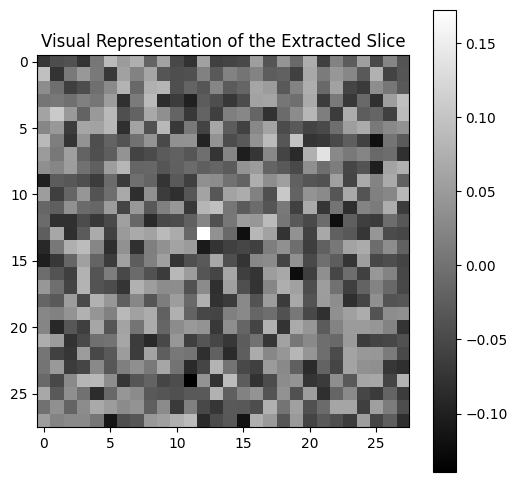

In [ ]:
slice_to_plot=layer1_receptivefield[:,:,20]
# Plotting the slice
plt.figure(figsize=(6, 6))
plt.imshow(slice_to_plot, cmap='gray')  # Use grayscale color map
plt.colorbar()  # Show color bar which maps values to colors
plt.title('Visual Representation of the Extracted Slice')
plt.show()

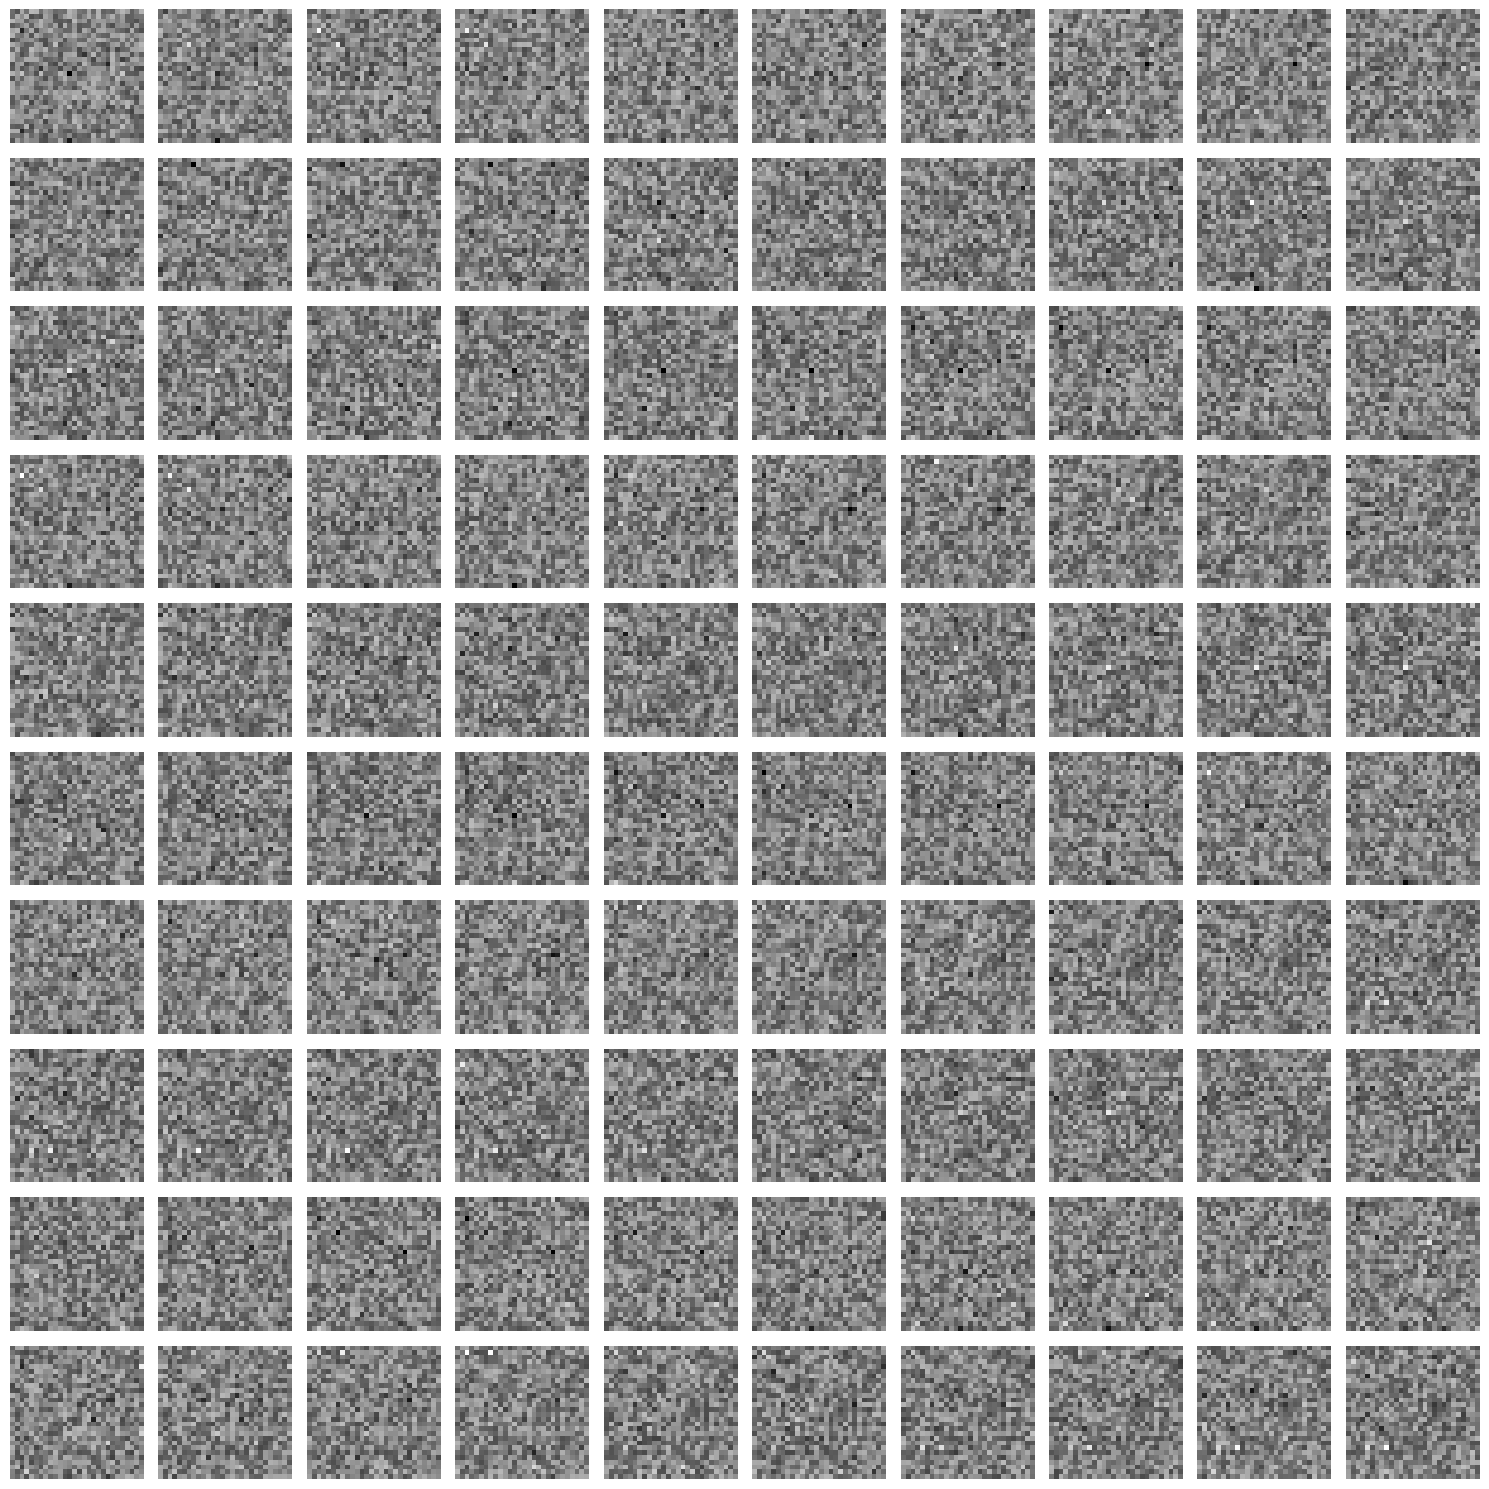

In [ ]:
# Number of slices to plot
num_slices = 100

# Create a figure with subplots in a 10x10 grid
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the first 100 slices
for i in range(num_slices):
    # Plot each slice
    ax = axes[i]
    ax.imshow(layer1_receptivefield[:, :, i], cmap='gray', vmin=-0.2, vmax=0.2)  # Adjust vmin and vmax appropriately
    ax.axis('off')  # Hide axes ticks

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# @title Main function run_backprop_model_mnist (reuse the cfg before for hyperparameters, model architecture etc.)

# Initialize seed if specified (might slow down the model) - this should have run before but let's state it again
if cfg['seed'] is not None:
    torch.manual_seed(cfg['seed'])

# Create activation functions for every layer as a list
phi = utils.create_activations(cfg['nonlinearity'], len(cfg['dimensions']))

if cfg['c_energy'] = 'squared_error':
  criterion = torch.nn.functional.mse_loss
elif cfg['c_energy'] = 'cross_entropy':
  criterion = torch.nn.functional.cross_entropy # it's classification so we use crossentropy
else:
  raise ValueError("c_energy \"{}\" not defined.".format(cfg['c_energy']))

cfg['energy'] = 'BP'
model = energy.MLP(
    cfg['dimensions'], cfg['batch_size'],phi).to(config.device)

print(model)

# Define optimizer (may include l2 regularization via weight_decay)
w_optimizer = utils.create_optimizer(model, cfg['optimizer'],  lr=cfg['learning_rate'])

logging.info("Start training with parametrization:\n{}".format(
    json.dumps(cfg, indent=4, sort_keys=True)))

for epoch in range(1, cfg['epochs'] + 1):
    # Training
    train.train_backprop(model, data_train, criterion, w_optimizer)

    # Testing
    test_acc, test_energy = train.test_backprop(model, data_test,criterion)

    # Logging
    logging.info(
        "epoch: {} \t test_acc: {:.4f} ".format(
            epoch, test_acc)
    )

[INFO  08:11:25] Start training with parametrization:
{
    "batch_size": 100,
    "beta": 1,
    "c_energy": "squared_error",
    "dataset": "mnist",
    "dimensions": [
        784,
        1000,
        10
    ],
    "dynamics": {
        "dt": 0.1,
        "n_relax": 50,
        "tau": 1,
        "tol": 0
    },
    "energy": "restr_hopfield",
    "epochs": 1,
    "fast_ff_init": false,
    "learning_rate": 0.001,
    "log_dir": "",
    "nonlinearity": "sigmoid",
    "optimizer": "adam",
    "seed": null
}


MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=10, bias=True)
  )
)


[INFO  08:11:26] [0/60000 (0%)]	Loss: 0.252224
[INFO  08:11:28] [6000/60000 (10%)]	Loss: 0.031685
[INFO  08:11:29] [12000/60000 (20%)]	Loss: 0.026064
[INFO  08:11:31] [18000/60000 (30%)]	Loss: 0.020284
[INFO  08:11:33] [24000/60000 (40%)]	Loss: 0.029132
[INFO  08:11:34] [30000/60000 (50%)]	Loss: 0.019507
[INFO  08:11:36] [36000/60000 (60%)]	Loss: 0.025215
[INFO  08:11:38] [42000/60000 (70%)]	Loss: 0.024002
[INFO  08:11:40] [48000/60000 (80%)]	Loss: 0.023578
[INFO  08:11:42] [54000/60000 (90%)]	Loss: 0.019355
[INFO  08:11:44] Epoch Finished: Avg. Loss: 0.0276, Accuracy: 82.11%
[INFO  08:11:46] Test Set: Avg. Loss: 0.0181, Accuracy: 90.61%
[INFO  08:11:46] epoch: 1 	 test_acc: 90.6100 


In [ ]:
del sys.modules['lib.train']
from lib import train,energy

In [ ]:
# @title Visualize model
print(model)
import graphviz

def visualize_hopfield_structure(model):
    dot = graphviz.Digraph()
    layers = len(model.W)  # Assuming model.W contains weights between layers

    # Add nodes for each layer
    for i in range(layers + 1):  # +1 because there are n+1 layers if there are n sets of weights
        dot.node(f'Layer {i}', f'Layer {i}')

    # Add edges between nodes
    for i in range(layers):
        dot.edge(f'Layer {i}', f'Layer {i + 1}', label=f'Weights {i}')

    return dot

# Assuming 'model' is an instance of RestrictedHopfield
model_dot = visualize_hopfield_structure(model)
model_dot.render('hopfield_structure', format='png', view=True)


RestrictedHopfield(
  (W): ModuleList(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=10, bias=True)
  )
)


'hopfield_structure.png'

In [ ]:
import graphviz

def visualize_hopfield_connections(model):
    dot = graphviz.Digraph(engine='dot', format='png')

    # Assuming model has an attribute 'W' that represents the weights between layers
    # and 'u' that might represent activations or states of each layer
    layers = len(model.W)  # Number of weight matrices should indicate the number of connections
    units_per_layer = [model.u[i].shape[1] for i in range(layers + 1)]  # +1 to include output layer units

    # Create subgraphs for layers
    for i in range(layers + 1):
        with dot.subgraph(name=f'cluster_{i}') as c:
            c.attr(label=f'Layer {i}')
            for j in range(units_per_layer[i]):
                c.node(f'n_{i}_{j}', f'Unit {j}')

    # Connect units between layers
    for i in range(layers):
        for j in range(model.W[i].weight.shape[0]):  # Rows in the weight matrix for layer i
            for k in range(model.W[i].weight.shape[1]):  # Columns in the weight matrix for layer i
                weight = model.W[i].weight[j, k].item()  # Getting the weight from PyTorch model
                dot.edge(f'n_{i}_{j}', f'n_{i+1}_{k}', label=f'{weight:.2f}')

    return dot

# Create a visualization of the model structure
# Assuming 'model' is properly defined with weights 'W' and states 'u'
model_dot = visualize_hopfield_connections(model)
model_dot.render('hopfield_network', view=True)

In [ ]:
model

NameError: name 'model' is not defined

In [ ]:
cfg

{'batch_size': 100,
 'beta': 1,
 'c_energy': 'squared_error',
 'dataset': 'mnist',
 'dimensions': [784, 1000, 10],
 'dynamics': {'dt': 0.1, 'n_relax': 50, 'tau': 1, 'tol': 0},
 'energy': 'restr_hopfield',
 'epochs': 1,
 'fast_ff_init': False,
 'learning_rate': 0.001,
 'nonlinearity': 'sigmoid',
 'optimizer': 'adam',
 'seed': None,
 'log_dir': ''}

In [ ]:
# can't get this to work

from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('log/example')
writer.add_graph(model)
writer.close()



!tensorboard --logdir=log

In [ ]:
def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    model_history = tl.log_forward_pass(model, imgs, layers_to_save='all', vis_opt=plot)
    model_features = {}
    for layer in return_layers:
        model_features[layer] = model_history[layer].tensor_contents.flatten(1)

    return model_features